# **Import all the relevant modules**

In [3]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, re

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn import metrics
from sklearn.metrics\
import accuracy_score as accuracy, recall_score as recall, precision_score as precision,\
      f1_score as f1, confusion_matrix, plot_roc_curve

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.tools


from time import time


# **Read in the Dataframe**

In [20]:
df = pd.read_excel('customer_churn.xlsx')
pd.set_option("display.max_columns", None)
df_working = df.copy()

# **EDA**

In [21]:
df_working.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,Competitor had better devices


In [22]:
## Check columns
df_working.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Reason'],
      dtype='object')

In [23]:
## and datatypes
df_working.dtypes

CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
Churn Value            int64
Churn Reason          object
dtype: object

In [24]:
### Check for null values - only Churn Reason has nulls for customers that haven't churn
df_working.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [25]:
##Country only has one value for all entries and hence gives us no information, so we drop the column
len(df_working['Country'].unique())

1

In [26]:
##this is the same for State 
len(df_working['State'].unique())

1

In [27]:
##this is the same for Count 
len(df_working['Count'].unique())

1

In [28]:
## Drop some unnecessary columns
df_working.drop(columns=['Count', 'Country', 'State', 'Lat Long', 'Churn Label'], inplace=True)

In [29]:
## Noticed total charges was an object - so replace blank entries with 0 and convert to float
df_working['Total Charges'] = df_working['Total Charges'].replace({' ': 0}).astype('float64')

In [30]:
## Convert the gender column into binary
## Also changed Payment Method column to 1 for automatic methods, 0 for non-automatic methods

def categorise(df): 
  df['Gender'] = df['Gender'].map( {'Female': 1, 'Male': 0} ).astype(int)

  df['Payment Method'] = df['Payment Method'].map( {'Mailed check': 0, 'Electronic check': 0, 'Bank transfer (automatic)' : 1, 'Credit card (automatic)' : 1 } )

  refactorColumns = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing']
  for column in refactorColumns:
    df[column] = df[column].map( {'No': 0, 'Yes':1} ).astype(int)
  return df

In [31]:
categorise(df_working)

,CustomerID,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Reason
0,3668-QPYBK,Los Angeles,90003,33.964131,-118.272783,0,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,0,53.85,108.15,1,Competitor made better offer
1,9237-HQITU,Los Angeles,90005,34.059281,-118.307420,1,0,0,1,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,0,70.70,151.65,1,Moved
2,9305-CDSKC,Los Angeles,90006,34.048013,-118.293953,1,0,0,1,8,1,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,1,0,99.65,820.50,1,Moved
3,7892-POOKP,Los Angeles,90010,34.062125,-118.315709,1,0,1,1,28,1,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,1,0,104.80,3046.05,1,Moved
4,0280-XJGEX,Los Angeles,90015,34.039224,-118.266293,0,0,0,1,49,1,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,1,1,103.70,5036.30,1,Competitor had better devices
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,Landers,92285,34.341737,-116.539416,1,0,0,0,72,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,1,1,21.15,1419.40,0,NaN
7039,6840-RESVB,Adelanto,92301,34.667815,-117.536183,0,0,1,1,24,1,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,1,0,84.80,1990.50,0,NaN
7040,2234-XADUH,Amboy,92304,34.559882,-115.637164,1,0,1,1,72,1,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,1,1,103.20,7362.90,0,NaN
7041,4801-JZAZL,Angelus Oaks,92305,34.167800,-116.864330,1,0,1,1,11,0,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,1,0,29.60,346.45,0,NaN


In [32]:
### Active Members
df_nochurn = df_working[df_working['Churn Value'] == 0].copy()
### Churned Members
df_churn = df_working[df_working['Churn Value'] == 1].copy()

[]

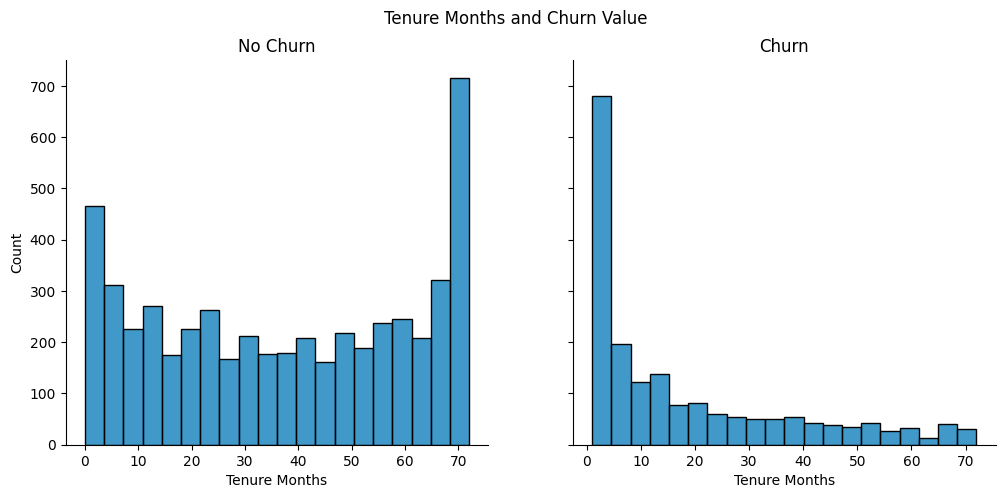

In [34]:
## Plot to look at tenure months for churners and non-churners

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle('Tenure Months and Churn Value')

# No Churn
sns.histplot(ax=axes[0], x='Tenure Months', data=df_nochurn, bins = 20, color = '#0077b6' )
axes[0].set_title('No Churn')

# Churn
sns.histplot(ax=axes[1], x='Tenure Months', data=df_churn, bins = 20, color = '#0077b6')
axes[1].set_title('Churn')

sns.despine()
plt.subplots_adjust(wspace = 0.2)
plt.plot()

[]

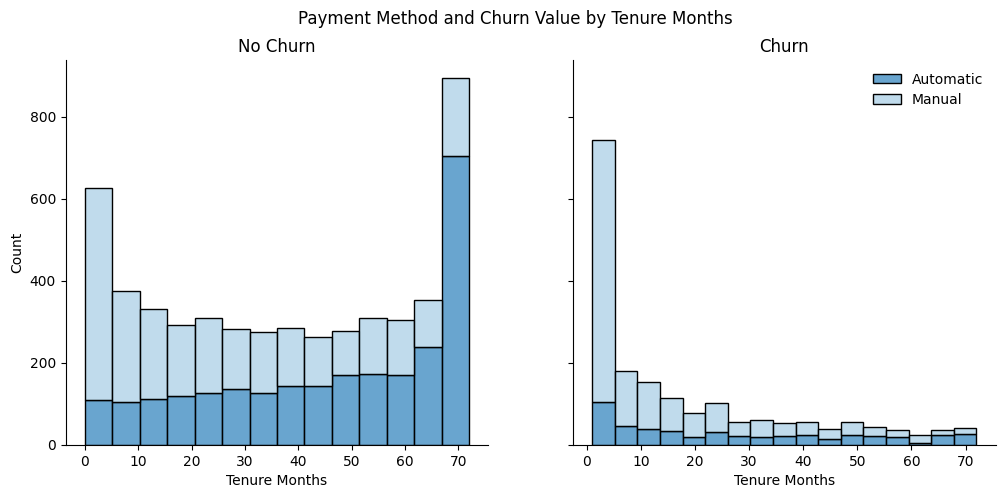

In [35]:
## Plot to look at Payment method for churners and non-churners (1 is automatic in this case)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle('Payment Method and Churn Value by Tenure Months')

# No Churn
sns.histplot(ax=axes[0], x='Tenure Months', hue='Payment Method', multiple='stack', data=df_nochurn, palette = 'Blues',legend=False)
axes[0].set_title('No Churn')

# Churn
sns.histplot(ax=axes[1], x='Tenure Months', hue='Payment Method', multiple='stack', data=df_churn, palette = 'Blues')
axes[1].set_title('Churn')
sns.despine()
plt.subplots_adjust(wspace = 0.2)

plt.legend(labels=['Automatic','Manual'],frameon=False)
plt.plot()

[]

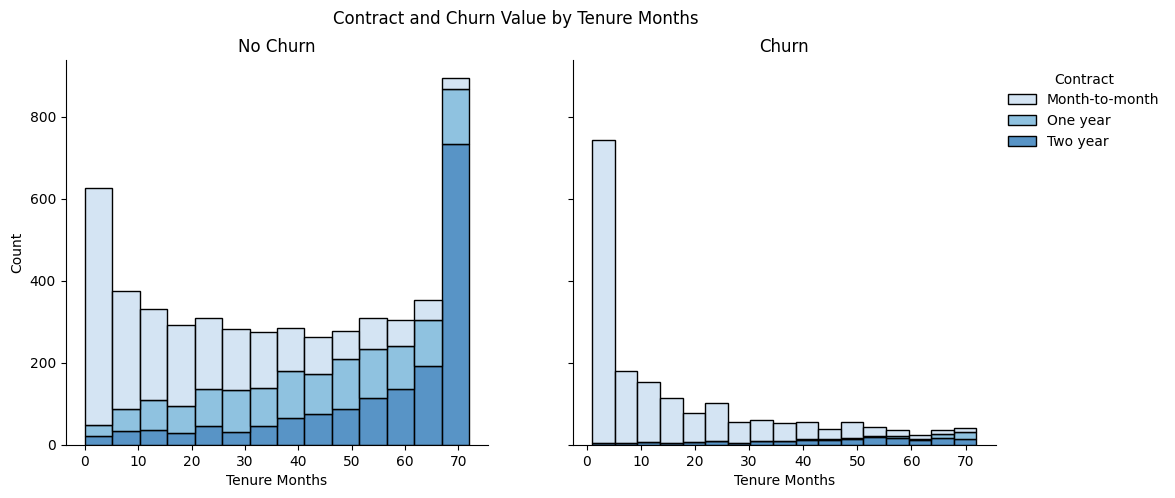

In [36]:
## Plot to compare the contract types and tenure months for churns and non-churners

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle('Contract and Churn Value by Tenure Months')

# No Churn
sns.histplot(ax=axes[0], x='Tenure Months', hue='Contract', multiple='stack', data=df_nochurn, palette = 'Blues')
axes[0].set_title('No Churn')
sns.move_legend(axes[0], "upper left", bbox_to_anchor=(2.2, 1), frameon=False)
# Churn
sns.histplot(ax=axes[1], x='Tenure Months', hue='Contract', multiple='stack', data=df_churn, palette = 'Blues')
axes[1].set_title('Churn')
axes[1].get_legend().remove()
sns.despine()
plt.subplots_adjust(wspace = 0.2)
plt.plot()

[]

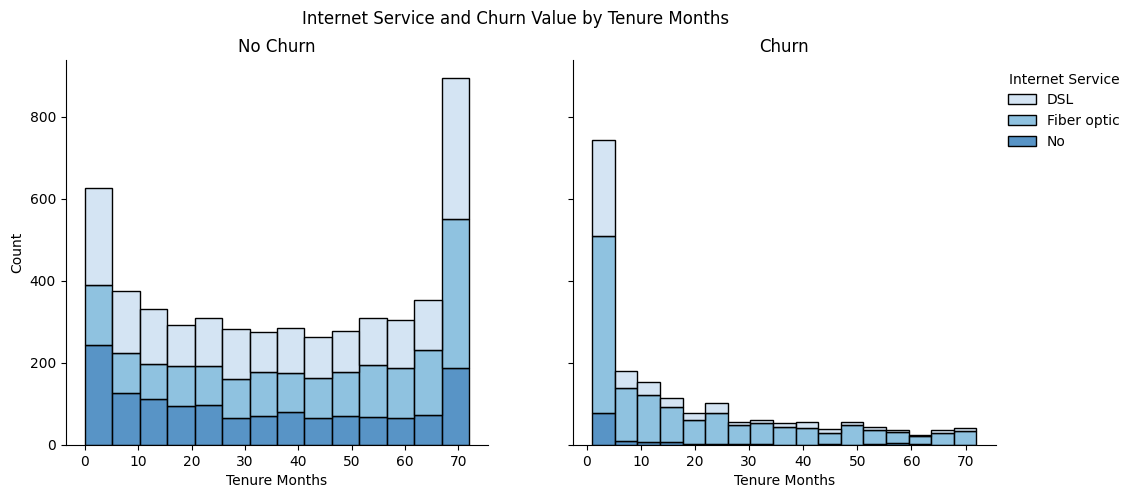

In [37]:
## Plot to compare the types of internet service and the number of tenure months of churners and non-churners 

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle('Internet Service and Churn Value by Tenure Months')

# No Churn
sns.histplot(ax=axes[0], x='Tenure Months', hue='Internet Service', multiple='stack', data=df_nochurn, palette ='Blues')
axes[0].set_title('No Churn')
sns.move_legend(axes[0], "upper left", bbox_to_anchor=(2.2, 1), frameon=False)


# Churn
sns.histplot(ax=axes[1], x='Tenure Months', hue='Internet Service', multiple='stack', data=df_churn, palette = 'Blues')
axes[1].set_title('Churn')
axes[1].get_legend().remove()
sns.despine()
plt.subplots_adjust(wspace = 0.2)

sns.despine()
plt.plot()

[]

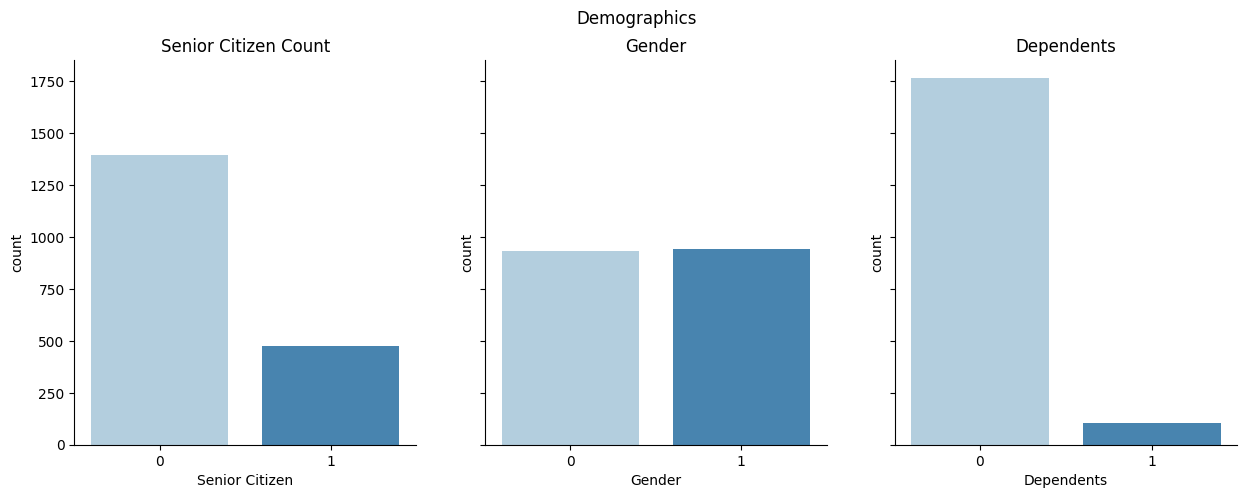

In [38]:
## Plot of the Demographics of Churners

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Demographics')

sns.countplot(ax=axes[0], data = df_churn, x = 'Senior Citizen', palette='Blues')
axes[0].set_title('Senior Citizen Count')

sns.countplot(ax=axes[1], data = df_churn, x = 'Gender', palette='Blues')
axes[1].set_title('Gender')

sns.countplot(ax=axes[2], data = df_churn, x = 'Dependents', palette='Blues')
axes[2].set_title('Dependents')

sns.despine()
plt.subplots_adjust(wspace = 0.2)
plt.plot()

[]

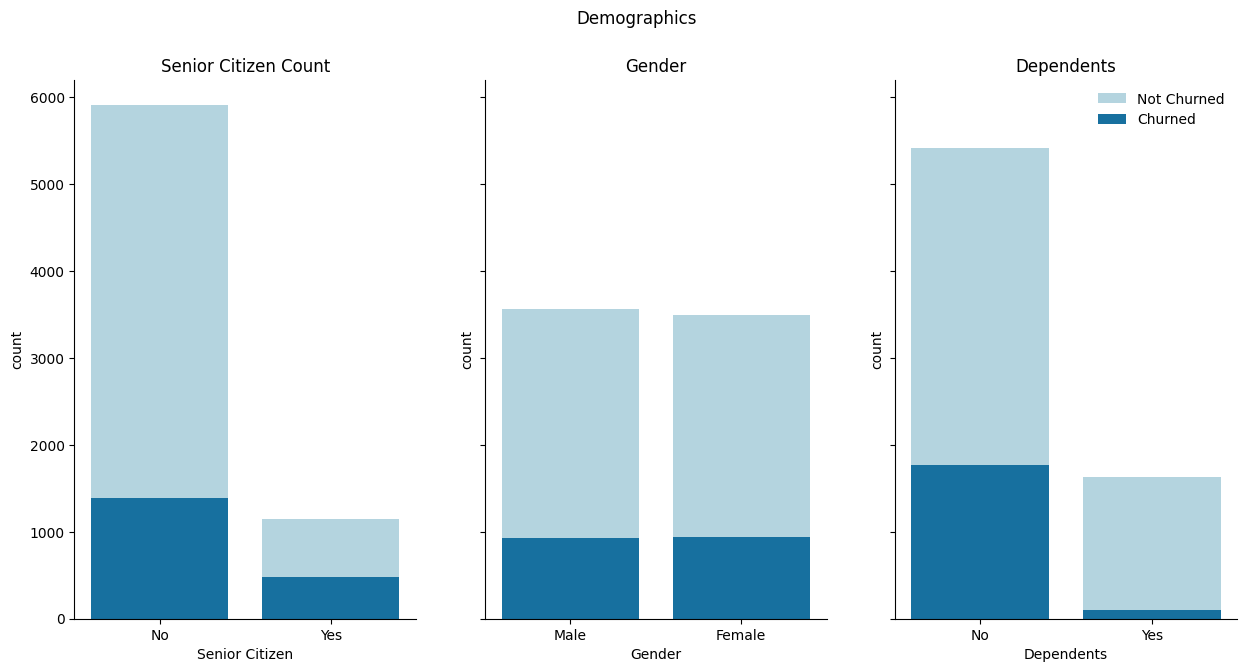

In [39]:
## Plot of the Demographics of churners compared to demographics of all customers

fig, axes = plt.subplots(1, 3, figsize=(15, 7), sharey=True)
fig.suptitle('Demographics')

sns.countplot(ax=axes[0], data = df, x = 'Senior Citizen', color = 'lightblue')
sns.countplot(ax=axes[0], data = df[df['Churn Value']==1], x = 'Senior Citizen',color = '#0077b6')
axes[0].set_title('Senior Citizen Count')

sns.countplot(ax=axes[1], data = df, x = 'Gender', color='lightblue')
sns.countplot(ax=axes[1], data = df[df['Churn Value']==1], x = 'Gender', color = '#0077b6')
axes[1].set_title('Gender')

sns.countplot(ax=axes[2], data = df, x = 'Dependents', color='lightblue')
sns.countplot(ax=axes[2], data = df[df['Churn Value']==1], x = 'Dependents', color = '#0077b6')
axes[2].set_title('Dependents')

sns.despine()
plt.legend(labels=['Not Churned','Churned'],frameon = False)
plt.subplots_adjust(wspace = 0.2)
plt.plot()

C:\Users\kathl\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


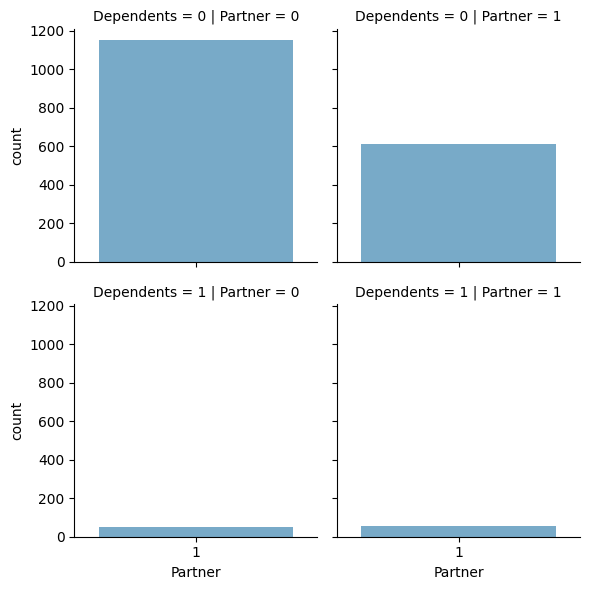

In [40]:
## Looking at the family make up of the churners
## Not many churners have dependents

g = sns.FacetGrid(df_churn, col="Partner", row="Dependents")
g.map(sns.countplot, "Partner", palette = 'Blues')
plt.show()

[]

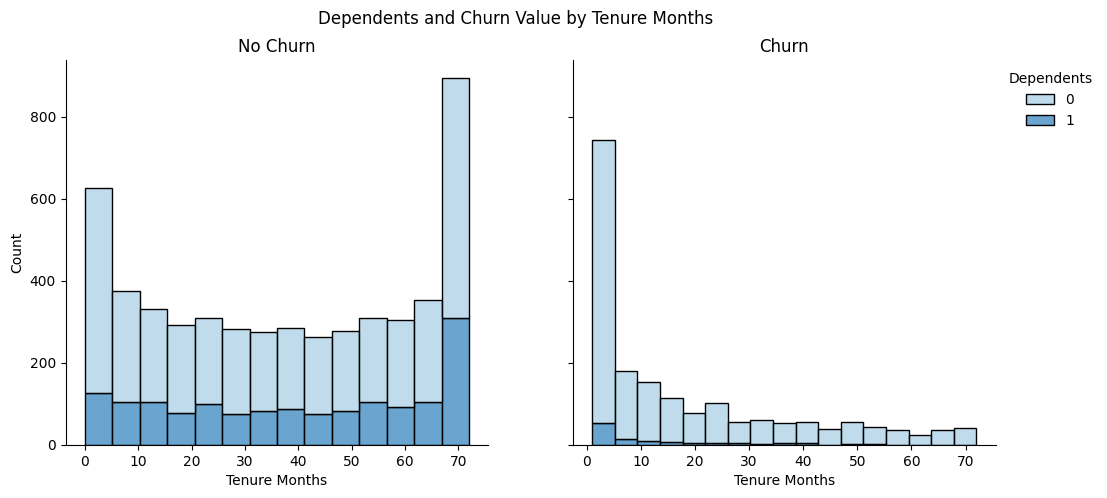

In [58]:
## Plot to look at the dependents of churners and non-churners on the tenure months graphs

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle('Dependents and Churn Value by Tenure Months')

# No Churn
sns.histplot(ax=axes[0], x='Tenure Months', hue='Dependents', multiple='stack', data=df_nochurn, palette='Blues')
axes[0].set_title('No Churn')
sns.move_legend(axes[0], "upper left", bbox_to_anchor=(2.2, 1), frameon=False)

# Churn
sns.histplot(ax=axes[1], x='Tenure Months', hue='Dependents', multiple='stack', data=df_churn, palette='Blues' )
axes[1].set_title('Churn')
axes[1].get_legend().remove()
plt.subplots_adjust(wspace = 0.2)


sns.despine()
plt.plot()

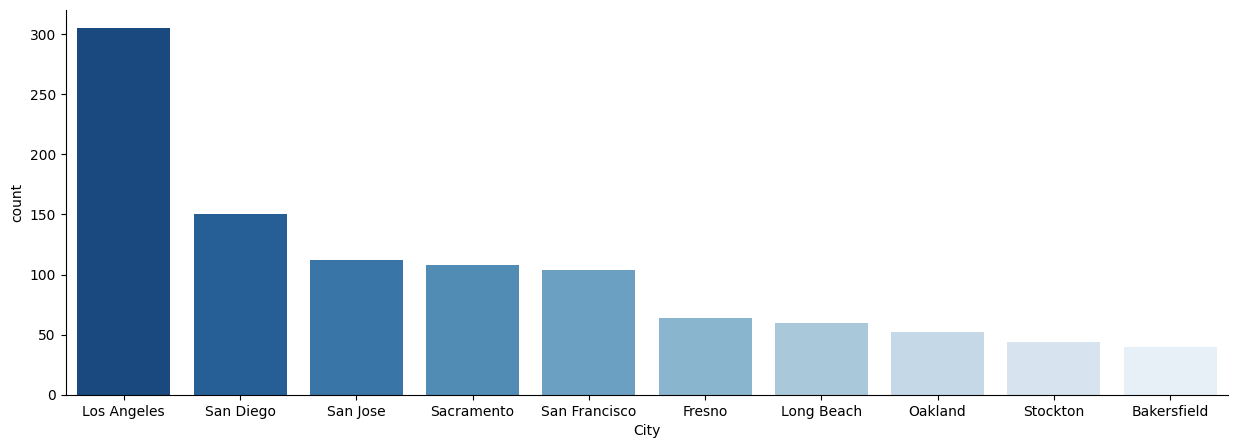

In [42]:
## Plot to see what cities most of the customers are in

plt.figure(figsize=[15,5])
sns.countplot(data= df_working, x = df['City'],palette="Blues_r", order=df.City.value_counts().iloc[:10].index)
sns.despine()
plt.show()

[]

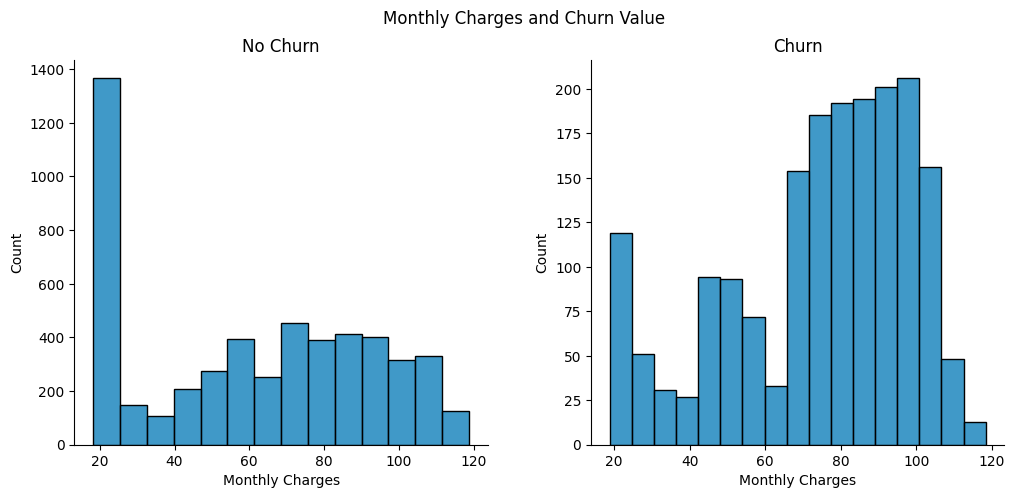

In [43]:
## Plot to see the monthly charges of churners and non-churners

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Monthly Charges and Churn Value')

# No Churn
sns.histplot(ax=axes[0], x='Monthly Charges', multiple='stack', data=df_nochurn, color='#0077b6')
axes[0].set_title('No Churn')

# Churn
sns.histplot(ax=axes[1], x='Monthly Charges', multiple='stack', data=df_churn, color='#0077b6')
axes[1].set_title('Churn')
sns.despine()
plt.subplots_adjust(wspace = 0.25)

sns.despine()
plt.plot()

In [44]:
## Looking at the churn reasons:

In [45]:
churn_reason_lst = df_churn['Churn Reason'].unique().tolist()
churn_reason_dict = dict(zip(churn_reason_lst, 'bebbbcdddddccceaaaae'))
df_churn = df_churn.replace({"Churn Reason": churn_reason_dict})

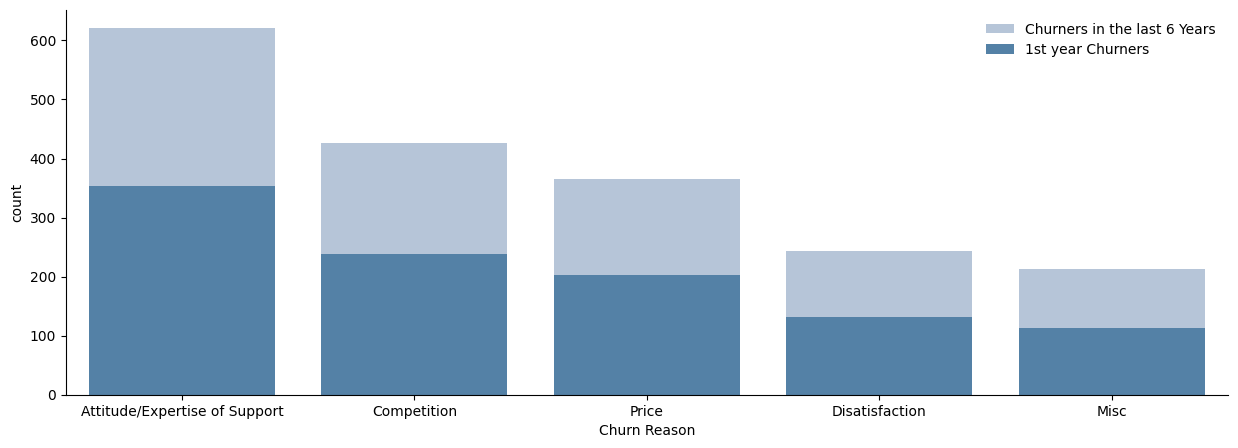

In [61]:
fig,ax = plt.subplots(figsize=[15,5])
sns.countplot(data = df_churn, x='Churn Reason', color = 'lightsteelblue', order=df_churn['Churn Reason'].value_counts().index)
sns.countplot(data = df_churn[df_churn['Tenure Months'] <= 12], x='Churn Reason', color = 'steelblue', order=df_churn['Churn Reason'].value_counts().index)
sns.despine()
plt.legend(labels=['Churners in the last 6 Years','1st year Churners'], frameon = False)
labels = ['Attitude/Expertise of Support','Competition','Price','Disatisfaction', 'Misc']
ax.set_xticklabels(['Attitude/Expertise of Support','Competition','Price','Disatisfaction', 'Misc'])
plt.show()

In [28]:
## Taking a closer look at the different internet products 

In [52]:
products = df_working[['Churn Value','Online Security', 'Online Backup','Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']].copy()

In [53]:
cols = ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support','Streaming TV', 'Streaming Movies']
for col in cols:
    products[col] = products[col].map({'No':0, 'No internet service':0, 'Yes':1})

In [54]:
products = products.groupby('Churn Value').sum()

In [55]:
products = products.transpose()

In [56]:
products
## This dataframe shows how many of the customers using these products churned

Churn Value,0,1
Online Security,1724,295
Online Backup,1906,523
Device Protection,1877,545
Tech Support,1734,310
Streaming TV,1893,814
Streaming Movies,1914,818


In [64]:
def categorise2(df):
  df['Multiple Lines'] = df['Multiple Lines'].map( {'Yes': 1, 'No': 0, 'No phone service' : 0} ).astype(int)

  refactorColumns = ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']
  for column in refactorColumns:
    df[column] = df[column].map( {'No': 0, 'No internet service': 0,  'Yes':1} ).astype(int)
  return df

In [65]:
df_working = categorise2(df_working)

# **Modelling**

##### **Functions**

In [66]:
def apr(y_pred, y_real):
  ''' Function to calculate model measurement metrics '''
  ## Using sklearn metrics, accuracy, precision, recall and f1 score is calculated
  accuracy = metrics.accuracy_score(y_real, y_pred)
  precision = metrics.precision_score(y_real, y_pred)
  recall = metrics.recall_score(y_real, y_pred)
  f1 = metrics.f1_score(y_real, y_pred)
  ## Aforementioned metrics are printed and returned to the program
  print(f"Accuracy:{accuracy}")
  print(f"Precision:{precision}")
  print(f"Recall:{recall}")
  print(f"F1:{f1}")
  #return accuracy, precision, recall, f1

In [67]:
def confusion(positive_label, negative_label, cm):
    ''' Function to plot the confusion matrix '''
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='Blues');    ## Plots confusion matric using an seaborn heatmap
    
    ax.set_xlabel('Predicted labels');ax.set_ylabel('Real labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels([negative_label, positive_label])
    ax.yaxis.set_ticklabels([negative_label, positive_label])

In [68]:
def checkVIF(X):
    '''Function to calculate the VIF of a dataframe '''
    vif = pd.DataFrame()                
    vif['Features'] = feature_cols      
    vif['VIF'] = [variance_inflation_factor(X[feature_cols].values, i) for i in range(X[feature_cols].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)  
    vif = vif.sort_values(by = "VIF", ascending = False) 
    return vif

In [69]:
def draw_roc( actual, probs ):
  ''' Function to calculate and plot the ROC curve '''
  fpr, tpr, thresholds = metrics.roc_curve( actual, probs, drop_intermediate = False)
  auc_score = metrics.roc_auc_score( actual, probs )
  plt.figure(figsize=(6, 6))
  plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()
  return None

### **Logistic Regression**

In [70]:
df_model = df_working.copy()  ## Model dataframe created from the cleaned dataframe from EDA

In [71]:
df_model.drop(columns=['CustomerID', 'Churn Reason', 'City', 'Zip Code', 'Latitude','Longitude'], inplace=True)   ## Dropped insignificant columns found from EDA 

In [72]:
df_model.shape    ## Returns a dataframe with 7043 rows by 20 columns

(7043, 20)

In [73]:
df_model.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,0,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,0,53.85,108.15,1
1,1,0,0,1,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,0,70.70,151.65,1
2,1,0,0,1,8,1,1,Fiber optic,0,0,1,0,1,1,Month-to-month,1,0,99.65,820.50,1
3,1,0,1,1,28,1,1,Fiber optic,0,0,1,1,1,1,Month-to-month,1,0,104.80,3046.05,1
4,0,0,0,1,49,1,1,Fiber optic,0,1,1,0,1,1,Month-to-month,1,1,103.70,5036.30,1


In [74]:
df_model.info(show_counts=True) ## NO NULLS & data types are as desired (object data type columns to be one-hot-encoded)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             7043 non-null   int32  
 1   Senior Citizen     7043 non-null   int32  
 2   Partner            7043 non-null   int32  
 3   Dependents         7043 non-null   int32  
 4   Tenure Months      7043 non-null   int64  
 5   Phone Service      7043 non-null   int32  
 6   Multiple Lines     7043 non-null   int32  
 7   Internet Service   7043 non-null   object 
 8   Online Security    7043 non-null   int32  
 9   Online Backup      7043 non-null   int32  
 10  Device Protection  7043 non-null   int32  
 11  Tech Support       7043 non-null   int32  
 12  Streaming TV       7043 non-null   int32  
 13  Streaming Movies   7043 non-null   int32  
 14  Contract           7043 non-null   object 
 15  Paperless Billing  7043 non-null   int32  
 16  Payment Method     7043 

**Train Test Split**

In [75]:
feature_cols = list(df_model)
feature_cols.remove('Churn Value')  ## Churn Value is the dependent variable in the modelling

X = df_model[feature_cols]
y = df_model['Churn Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)   ## Train and Test split 80:20, respectively, with a random state

**Feature Engineering**

In [76]:
def feature_eng(df, Bool):    ## Added Boolean atribute, depending on whether the model is parametric
  ''' Feature engineer function to one-hot-encode the categorical columns '''
  df = pd.get_dummies(df, columns = ['Internet Service'], drop_first = Bool, prefix = 'internet_service') 
  df = pd.get_dummies(df, columns = ['Contract'], drop_first = Bool, prefix = 'contract')
  return df

In [77]:
X_train = feature_eng(X_train, True)    ## Applying the feature engineering function to the X_train data - set drop first to True

In [78]:
feature_cols = list(X_train)    ## Relisting the feature columns after the feature engineering

In [79]:
## Scaling the continous data using the MinMax Scaler
scaler = MinMaxScaler()
scaler.fit(X_train[['Total Charges','Monthly Charges', 'Tenure Months']]) ## Fitting scaling to the X_train data
X_train[['Total Charges','Monthly Charges', 'Tenure Months']] = scaler.transform(X_train[['Total Charges','Monthly Charges', 'Tenure Months']]) ## Transforming the scaling function

In [80]:
## Columns removed from the model due to high VIF number
for column in ['Phone Service', 'Total Charges', 'internet_service_Fiber optic']:
  feature_cols.remove(column) 

**Logistic Regression Modelling**

In [81]:
lr = LogisticRegression(max_iter=300, random_state = 10)
lr.fit(X_train[feature_cols], y_train)
X_train[['notchurnprob', 'churnprob']] = lr.predict_proba(X_train[feature_cols])
X_train['y_pred'] = np.where(X_train['churnprob']>0.42, 1, 0)

In [82]:
apr(X_train['y_pred'], y_train)

Accuracy:0.8024494142705005
Precision:0.6118090452261307
Recall:0.6630360789652825
F1:0.6363933355112709


In [83]:
checkVIF(X_train)   ## Removed Phone Service, Total Charges, internet_service_Fiber optic due to considerably high VIF

,Features,VIF
14,Monthly Charges,10.78
4,Tenure Months,7.50
17,contract_Two year,3.44
11,Streaming Movies,2.97
10,Streaming TV,2.87
12,Paperless Billing,2.67
2,Partner,2.62
5,Multiple Lines,2.59
8,Device Protection,2.31
7,Online Backup,2.15


In [84]:
confusion_train = confusion_matrix(X_train['y_pred'],y_train)

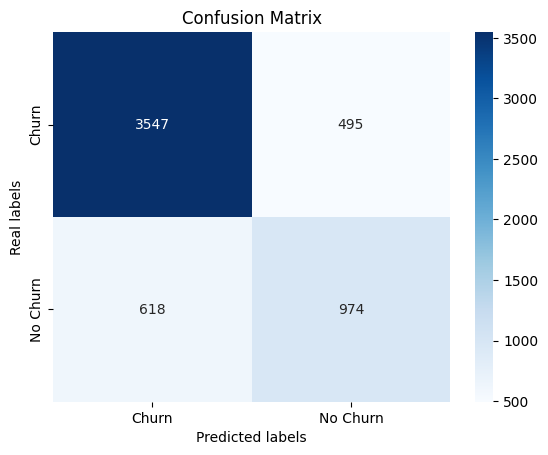

In [85]:
confusion('No Churn', 'Churn', confusion_train)

**Test Data**

In [86]:
X_test = feature_eng(X_test, True)  ## Feature Engineering the test data

In [87]:
X_test[['Total Charges','Monthly Charges', 'Tenure Months']] = scaler.transform(X_test[['Total Charges','Monthly Charges', 'Tenure Months']])   ## Scale transforming the X_test continous data columns

In [88]:
X_test[['notchurnprob', 'churnprob']] = lr.predict_proba(X_test[feature_cols])
X_test['y_pred'] = np.where(X_test['churnprob']>0.42, 1, 0)

In [89]:
apr(X_test['y_pred'], y_test)

Accuracy:0.7899219304471257
Precision:0.6203703703703703
Recall:0.67
F1:0.6442307692307693


In [90]:
confusion_test = confusion_matrix(X_test['y_pred'],y_test)

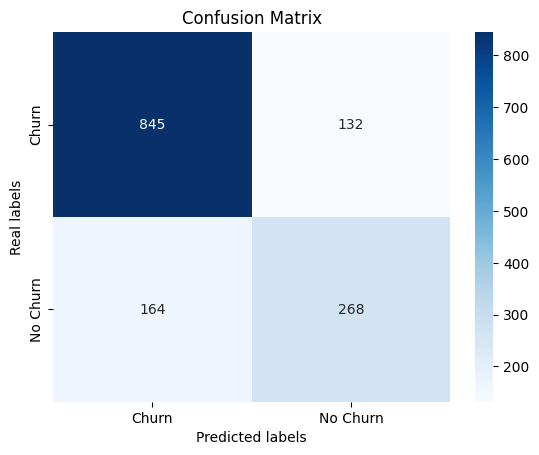

In [91]:
confusion('No Churn', 'Churn', confusion_test)

**Dataframe of Customer ID, Churn Probability and Churn Predict**

X_train

In [92]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':X_train['churnprob'], 'Churn_Pred':X_train['y_pred']}).reset_index()
y_train_pred_final.drop(columns=['index'], inplace = True)
y_train_pred_final['CustID'] = y_train.index

X_test

In [93]:
y_test_pred_final = pd.DataFrame({'Churn':y_test.values, 'Churn_Prob':X_test['churnprob'], 'Churn_Pred':X_test['y_pred']}).reset_index()
y_test_pred_final.drop(columns=['index'], inplace = True)
y_test_pred_final['CustID'] = y_test.index

Combined

In [94]:
y_pred_final = pd.concat([y_train_pred_final,y_test_pred_final])

**ROC**

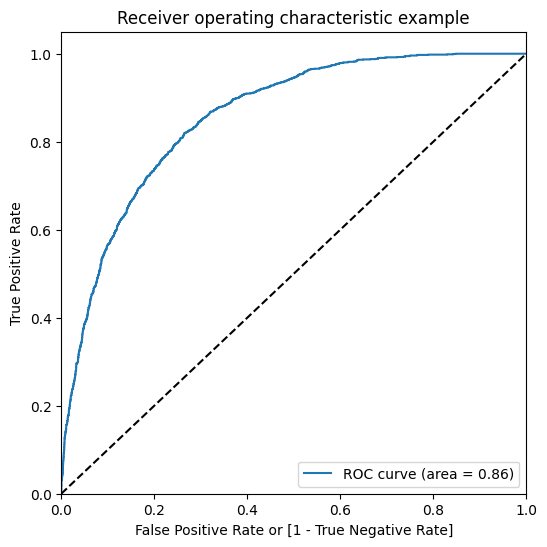

In [95]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

In [96]:
fpr, tpr, thresholds = metrics.roc_curve( y_test_pred_final.Churn, y_test_pred_final.Churn_Prob, drop_intermediate = False )

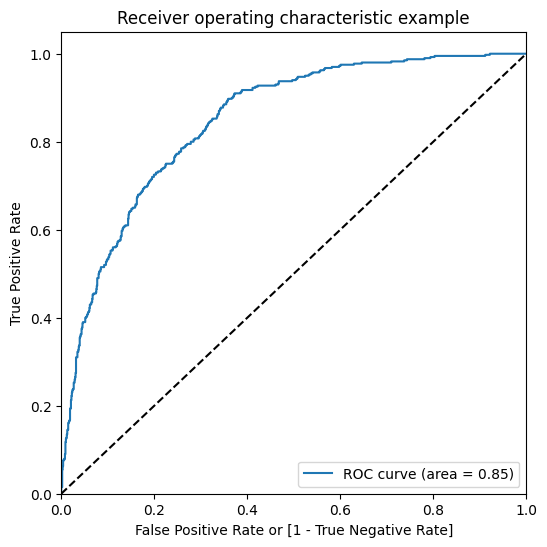

In [97]:
draw_roc(y_test_pred_final.Churn, y_test_pred_final.Churn_Prob)

**Top 500 Most Likely to Churn**

In [98]:
y_pred_final[y_pred_final['Churn'] == 0].sort_values(by='Churn_Prob', ascending = False).reset_index(drop=True).head(500)

,Churn,Churn_Prob,Churn_Pred,CustID
0,0,0.840020,1,4198
1,0,0.835951,1,2567
2,0,0.832527,1,3732
3,0,0.824091,1,4624
4,0,0.809432,1,4927
...,...,...,...,...
495,0,0.515860,1,3698
496,0,0.515242,1,6946
497,0,0.514978,1,2343
498,0,0.514795,1,5903


## **Decision Tree Model**

**Train Test Split**

In [99]:
feature_cols = list(df_model)
feature_cols.remove('Churn Value')

X = df_model[feature_cols]
y = df_model['Churn Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

**Feature Engineering**

In [100]:
X_train = feature_eng(X_train, False)    ## Using the same feature enginnering as used in the Logistic Regression

In [101]:
feature_cols = list(X_train)

In [102]:
## Scaling the continous data using the MinMax Scaler
scaler = MinMaxScaler()
scaler.fit(X_train[['Total Charges','Monthly Charges', 'Tenure Months']]) ## Fitting scaling to the X_train data
X_train[['Total Charges','Monthly Charges', 'Tenure Months']] = scaler.transform(X_train[['Total Charges','Monthly Charges', 'Tenure Months']]) ## Transforming the scaling function
X_test[['Total Charges','Monthly Charges', 'Tenure Months']] = scaler.transform(X_test[['Total Charges','Monthly Charges', 'Tenure Months']])

**Decision Tree Modelling**

In [103]:
treeclf = DecisionTreeClassifier()  ## Defining the Decision Tree Function
treeclf.fit(X_train, y_train)

DecisionTreeClassifier()

In [104]:
treeclf.classes_

array([0, 1], dtype=int64)

In [105]:
X_test = feature_eng(X_test, False)    ## Feature engineering the X_test

In [ ]:
grid = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = {'max_depth': [5, 7, 10, 11],
                                  'min_samples_split': [10, 15, 20, 30, 50, 100, 150],
                                  'min_samples_leaf': [20, 50, 100, 150, 200, 250],
                                  'max_features': [13,15,17,19,21], 
                                  'criterion': ["entropy", "gini"]},
                    cv = 5,
                    refit = True,
                    verbose = 1,
                    scoring = 'accuracy')

now = time()

grid.fit(X_train, y_train)

print(f' Time in seconds: {time() - now}')

Fitting 5 folds for each of 1680 candidates, totalling 8400 fits


In [ ]:
grid.best_params_

In [ ]:
grid.best_score_

In [85]:
grid.best_estimator_

DecisionTreeClassifier(max_depth=11, max_features=19, min_samples_leaf=50,
                       min_samples_split=30)

In [86]:
dt = DecisionTreeClassifier(max_depth=7, max_features=21, min_samples_leaf=50,
                       min_samples_split=10)

In [87]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, max_features=21, min_samples_leaf=50,
                       min_samples_split=10)

In [88]:
print(f'Accuracy on training set: {dt.score(X_train, y_train)}')
print(f'Accuracy on testing set: {dt.score(X_test, y_test)}')

Accuracy on training set: 0.8132765353212638
Accuracy on testing set: 0.7984386089425124


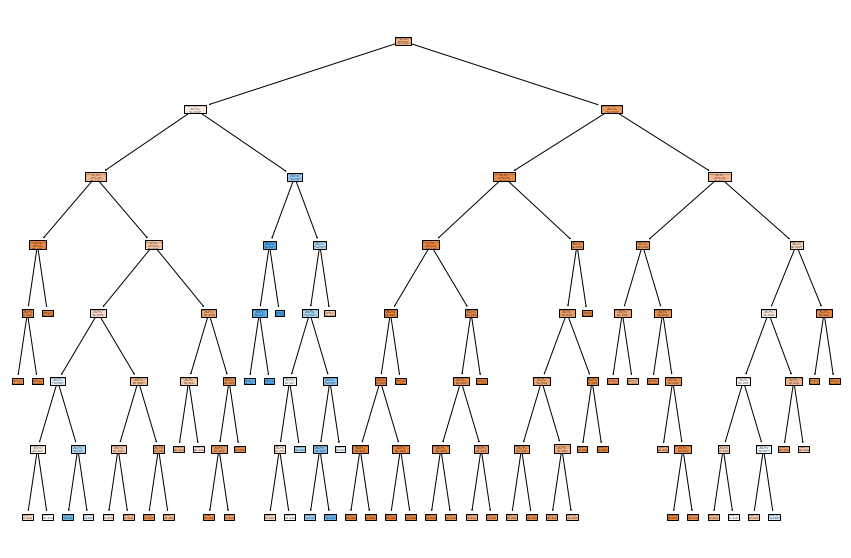

In [89]:
fig = plt.figure(figsize=(15,10))
thing = tree.plot_tree(dt, 
                   feature_names=feature_cols,  
                   class_names=['no churn', 'churn'],
                   filled=True)

## **Random Forests**

**Train Test Splt**

In [90]:
feature_cols = list(df_model)
feature_cols.remove('Churn Value')

X = df_model[feature_cols]
y = df_model['Churn Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

**Feature Engineering**

In [91]:
X_train = feature_eng(X_train, False)   ## Feature engineering with drop first set to false as random forests are non-parametric

In [92]:
X_test = feature_eng(X_test, False)

In [93]:
feature_cols = list(X_train)

In [94]:
## Scaling the continous data using the MinMax Scaler
scaler = MinMaxScaler()
scaler.fit(X_train[['Total Charges','Monthly Charges', 'Tenure Months']]) ## Fitting scaling to the X_train data
X_train[['Total Charges','Monthly Charges', 'Tenure Months']] = scaler.transform(X_train[['Total Charges','Monthly Charges', 'Tenure Months']]) ## Transforming the scaling function
X_test[['Total Charges','Monthly Charges', 'Tenure Months']] = scaler.transform(X_test[['Total Charges','Monthly Charges', 'Tenure Months']])

**Random Forest Modelling**

In [95]:
rf = RandomForestClassifier()   ## Defining the Random Forest Classifier

In [96]:
## Used the GridSearch to find 
rf_params = {
    'max_depth': [8,9,10],
    'min_samples_leaf': [5,10,15,20],
    'n_estimators': [10, 25, 50, 100,150,200]
}

cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)

gs = GridSearchCV(rf, param_grid=rf_params, refit = True, cv=cv,  n_jobs=-1)  

gs.fit(X_train, y_train)

print(gs.best_score_)   

gs.best_params_

0.809639266706091


{'max_depth': 10, 'min_samples_leaf': 20, 'n_estimators': 100}

In [97]:
rf_best = gs.best_estimator_
rf_best

RandomForestClassifier(max_depth=10, min_samples_leaf=20)

In [98]:
rf = RandomForestClassifier(max_depth=8, min_samples_leaf=10, n_estimators=200)

In [99]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=10, n_estimators=200)

In [100]:
rf.score(X_train, y_train)

0.8260560880369187

In [101]:
rf.score(X_test, y_test)

0.8019872249822569

In [102]:
X_train['y_pred'] = rf.predict(X_train)

In [103]:
confusion_train = confusion_matrix(X_train['y_pred'],y_train)

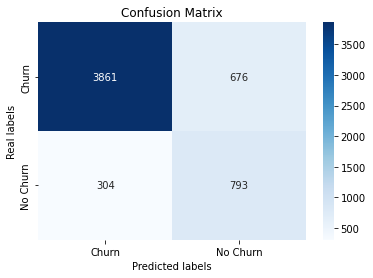

In [104]:
confusion('No Churn', 'Churn', confusion_train)

In [105]:
apr(X_train['y_pred'], y_train)

Accuracy:0.8260560880369187
Precision:0.7228805834092981
Recall:0.5398230088495575
F1:0.6180826188620421


In [106]:
X_test['y_pred'] = rf.predict(X_test)

In [107]:
confusion_test = confusion_matrix(X_test['y_pred'],y_test)

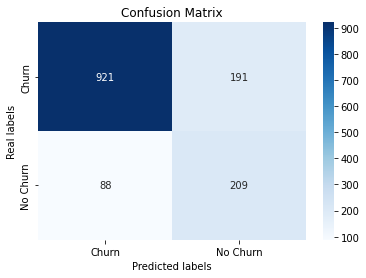

In [108]:
confusion('No Churn', 'Churn', confusion_test)

In [109]:
apr(X_test['y_pred'], y_test)

Accuracy:0.8019872249822569
Precision:0.7037037037037037
Recall:0.5225
F1:0.599713055954089


**Dataframe of Customer ID, Churn Probability and Churn Predict**

X_train

In [110]:
X_train[['notchurnprob', 'churnprob']] = rf.predict_proba(X_train[feature_cols])

In [111]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':X_train['churnprob']}).reset_index()
y_train_pred_final.drop(columns=['index'], inplace = True)
y_train_pred_final['CustID'] = y_train.index

X_test

In [112]:
X_test[['notchurnprob', 'churnprob']] = rf.predict_proba(X_test[feature_cols])

In [113]:
y_test_pred_final = pd.DataFrame({'Churn':y_test.values, 'Churn_Prob':X_test['churnprob']}).reset_index()
y_test_pred_final.drop(columns=['index'], inplace = True)
y_test_pred_final['CustID'] = y_test.index

Combined

In [114]:
y_pred_final = pd.concat([y_train_pred_final,y_test_pred_final])

**ROC**

In [115]:
fpr, tpr, thresholds = metrics.roc_curve(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )

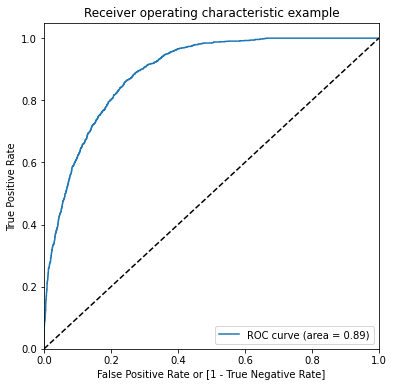

In [116]:
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

In [117]:
fpr, tpr, thresholds = metrics.roc_curve( y_test_pred_final.Churn, y_test_pred_final.Churn_Prob, drop_intermediate = False )

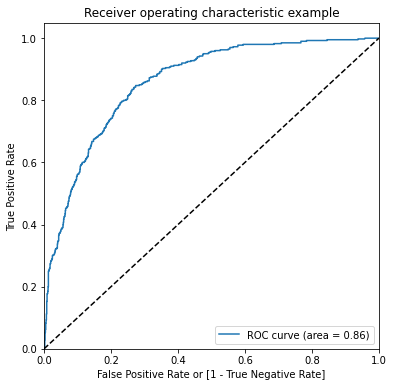

In [118]:
draw_roc(y_test_pred_final.Churn, y_test_pred_final.Churn_Prob)

**Top 500 Most Likely to Churn**

As accuracy was higher with the Random Forest Trees Classifier, the churn probabilities will be taken from this model.

In [119]:
 ## Sorts the data frame by Churn probability, excluding those who have already churned
Churn_Predictions = y_pred_final[y_pred_final['Churn'] == 0].sort_values(by='Churn_Prob', ascending = False).reset_index(drop=True).copy()

In [120]:
Churn_Predictions = Churn_Predictions.drop(columns= 'Churn')

In [121]:
## CSV files of the total present customer list and their churn probability, and the top 500 of said customers
Churn_Predictions.to_csv('TotalChurnRisk.csv')
Churn_Predictions.head(500).to_csv('Top500ChurnRisk.csv')

In [122]:
Churn_Predictions.head(500).to_csv('Top500ChurnRisk.csv')

**Feature Importance**

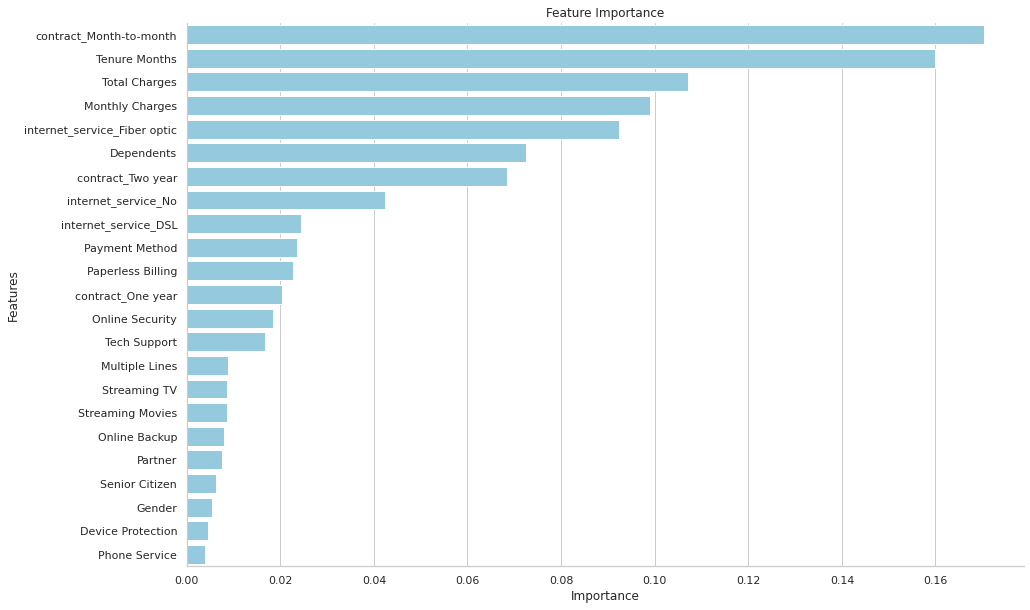

In [123]:
feats = {}
for feature, importance in zip(feature_cols, rf_best.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})


sns.set(style="whitegrid")
plt.figure(figsize=[15,10])
sns.barplot(x=importances['Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
sns.despine()
plt.show()